In [1]:
#Import Kaggle dataset
import os
from pathlib import Path

os.environ["KAGGLE_KEY"] = os.getenv('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = os.getenv('KAGGLE_USERNAME')


In [11]:
import kagglehub

asl_dataset = "ayuraj/asl-dataset"
asl_alphabet = "grassknoted/asl-alphabet"
path = kagglehub.dataset_download(asl_alphabet)
print(f"Path to dataset files:{path}")


100%|██████████| 1.03G/1.03G [02:10<00:00, 8.46MB/s]

Extracting files...


Path to dataset files:/home/mich02/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [ ]:
# First dataset
!apt-get install tree
!kaggle datasets download -d ayuraj/asl-dataset
! unzip -q "/content/asl-dataset.zip"

!kaggle datasets download -d grassknoted/asl-alphabet
! unzip -q "/content/asl-alphabet.zip"

!mv asl_alphabet_train/asl_alphabet_train/* asl_alphabet_train/
!rm -r asl_alphabet_train/asl_alphabet_train/
!mv asl_alphabet_test/asl_alphabet_test/* asl_alphabet_test/
!rm -r asl_alphabet_test/asl_alphabet_test/

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
User cancelled operation
^C
unzip:  cannot find or open /content/asl-dataset.zip, /content/asl-dataset.zip.zip or /content/asl-dataset.zip.ZIP.
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0


/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored in: <function tqdm.__del__ at 0x7bfc34492c00>
Traceback (most recent call last):
  File "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Found 2515 images to process
Using 22 workers


Saving random-bg dataset: 100%|██████████| 2515/2515 [00:48<00:00, 51.38it/s]



Done. Saved: 2515  |  Failed: 0  |  Out dir: /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise


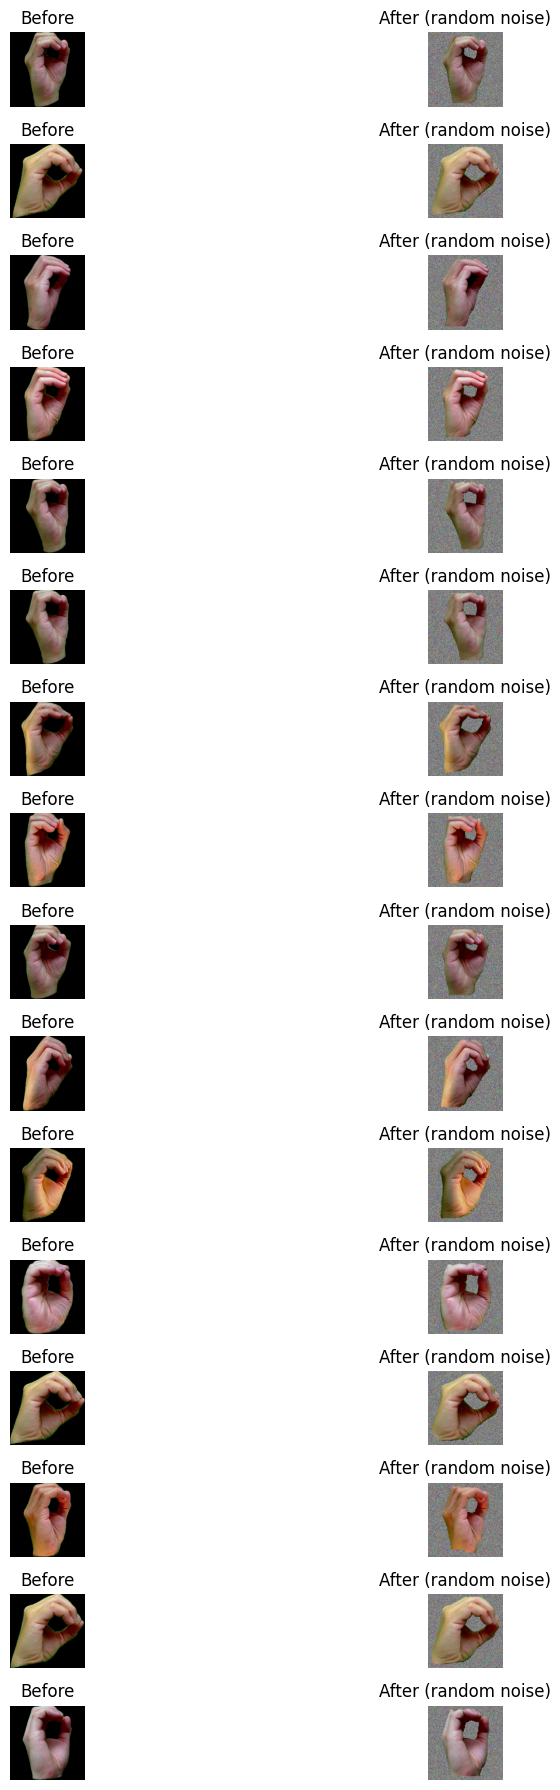

In [4]:
# ===================== Random BG saver - Local Machine Version =====================
# Saves outputs to a new dataset folder, preserving 0-9/a-z subfolders
# ====================================================================================

import os
import glob
import random
from typing import List, Tuple
from pathlib import Path

import numpy as np
import cv2

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from tqdm.auto import tqdm


# -------------------- helpers --------------------
def list_images_recursive(root: str, exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")) -> List[str]:
    root = os.path.abspath(root)
    paths = []
    for d in sorted(os.listdir(root)):
        sub = os.path.join(root, d)
        if not os.path.isdir(sub):
            continue
        for ext in exts:
            paths.extend(glob.glob(os.path.join(sub, f"*{ext}")))
    return paths

def _read_image_any(x):
    if isinstance(x, str):
        img = cv2.imread(x, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {x}")
    elif isinstance(x, np.ndarray):
        img = x.copy()
    else:
        raise TypeError("Each item must be a file path or a NumPy array.")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.ndim == 3 and img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def _grabcut_mask(img, rect_margin: float = 0.05, iters: int = 5):
    h, w = img.shape[:2]
    if img.shape[2] == 4:
        bgr = img[:, :, :3]
        alpha = img[:, :, 3]
        alpha_norm = (alpha > 0).astype(np.uint8)
    else:
        bgr = img
        alpha_norm = None

    x0 = int(w * rect_margin); y0 = int(h * rect_margin)
    x1 = int(w * (1.0 - rect_margin)); y1 = int(h * (1.0 - rect_margin))
    rect = (x0, y0, max(1, x1 - x0), max(1, y1 - y0))

    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    if alpha_norm is not None:
        mask[alpha_norm == 1] = cv2.GC_FGD
        mask[:2, :] = cv2.GC_BGD; mask[-2:, :] = cv2.GC_BGD
        mask[:, :2] = cv2.GC_BGD; mask[:, -2:] = cv2.GC_BGD
        cv2.grabCut(bgr, mask, None, bgdModel, fgdModel, iters, mode=cv2.GC_INIT_WITH_MASK)
    else:
        cv2.grabCut(bgr, mask, rect, bgdModel, fgdModel, iters, mode=cv2.GC_INIT_WITH_RECT)

    return (mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD)

def _random_bg(h: int, w: int, mode: str, rng: np.random.Generator):
    mode = (mode or "noise").lower()
    if mode not in ("noise", "solid"):
        mode = "noise"
    if mode == "noise":
        return rng.integers(0, 256, size=(h, w, 3), dtype=np.uint8)
    color = rng.integers(0, 256, size=(1, 1, 3), dtype=np.uint8)
    return np.tile(color, (h, w, 1))

def _process_one(
    in_path: str,
    out_root: str,
    src_root: str,
    random_mode: str,
    iters: int,
    rect_margin: float,
    seed: int | None,
    seq_index: int,
) -> Tuple[str, str, bool]:
    """Returns (in_path, out_path, ok)."""
    try:
        rng = np.random.default_rng(
            np.random.SeedSequence([seed, seq_index]).generate_state(4, dtype=np.uint64)
        ) if seed is not None else np.random.default_rng()

        img_in = _read_image_any(in_path)
        has_alpha = (img_in.shape[2] == 4)
        bgr = img_in[:, :, :3] if has_alpha else img_in
        alpha = img_in[:, :, 3:4] if has_alpha else None

        fg_mask = _grabcut_mask(img_in, rect_margin=rect_margin, iters=iters)
        h, w = bgr.shape[:2]
        rb = _random_bg(h, w, random_mode, rng)
        out = bgr.copy()
        out[~fg_mask] = rb[~fg_mask]
        if has_alpha:
            out = np.concatenate([out, alpha], axis=2)

        # Determine output path (mirror folder structure)
        rel = os.path.relpath(in_path, start=src_root)
        rel_noext = os.path.splitext(rel)[0]
        # If alpha exists, prefer PNG to preserve it; else keep original extension
        if has_alpha:
            out_path = os.path.join(out_root, rel_noext + ".png")
        else:
            out_path = os.path.join(out_root, rel)

        out_dir = os.path.dirname(out_path)
        os.makedirs(out_dir, exist_ok=True)

        # Save (cv2 expects BGR/BGRA)
        ok = cv2.imwrite(out_path, out)
        return in_path, out_path, bool(ok)
    except Exception as e:
        print(f"Error processing {in_path}: {e}")
        return in_path, "", False


# -------------------- main API --------------------
def save_random_bg_dataset(
    src_root: str,
    out_root: str,
    random_mode: str = "noise",  # "noise" or "solid"
    n_workers: int | None = None,
    iters: int = 5,
    rect_margin: float = 0.05,
    seed: int | None = 123,
    preview: int = 12,            # visualize a few samples after saving
    figsize=(12, 10),
) -> None:
    src_root = os.path.abspath(src_root)
    out_root = os.path.abspath(out_root)
    paths = list_images_recursive(src_root)
    if not paths:
        raise ValueError(f"No images found under: {src_root}")

    if n_workers is None or n_workers < 1:
        n_workers = max(1, mp.cpu_count() - 1)  # Use all cores minus 1

    print(f"Found {len(paths)} images to process")
    print(f"Using {n_workers} workers")

    # Process + save with threads
    successes = 0
    failures = 0
    befores, afters = [], []

    with ThreadPoolExecutor(max_workers=n_workers) as ex:
        futures = [
            ex.submit(
                _process_one, p, out_root, src_root,
                random_mode, iters, rect_margin, seed, i
            )
            for i, p in enumerate(paths)
        ]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Saving random-bg dataset"):
            in_path, out_path, ok = f.result()
            if ok:
                successes += 1
                # Collect a few examples for preview
                if len(befores) < preview:
                    img_in = _read_image_any(in_path)
                    img_out = _read_image_any(out_path)
                    b_disp = cv2.cvtColor(img_in, cv2.COLOR_BGRA2RGBA) if (img_in.ndim == 3 and img_in.shape[2] == 4) \
                             else cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
                    a_disp = cv2.cvtColor(img_out, cv2.COLOR_BGRA2RGBA) if (img_out.ndim == 3 and img_out.shape[2] == 4) \
                             else cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
                    befores.append(b_disp); afters.append(a_disp)
            else:
                failures += 1

    # Quick report
    print(f"\nDone. Saved: {successes}  |  Failed: {failures}  |  Out dir: {out_root}")

    # Optional preview grid
    n_show = min(preview, len(befores))
    if n_show > 0:
        cols = 2; rows = n_show
        plt.figure(figsize=figsize)
        for i in range(n_show):
            ax1 = plt.subplot(rows, cols, 2*i + 1)
            ax1.imshow(befores[i]); ax1.set_title("Before"); ax1.axis("off")
            ax2 = plt.subplot(rows, cols, 2*i + 2)
            ax2.imshow(afters[i]); ax2.set_title(f"After (random {random_mode})"); ax2.axis("off")
        plt.tight_layout(); plt.show()


# -------------------- run it --------------------
SRC = "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset"
OUT = "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise"

save_random_bg_dataset(
    SRC, OUT,
    random_mode="noise",   # or "solid"
    n_workers=22,           # Adjust based on your CPU cores
    iters=5,
    rect_margin=0.05,
    seed=7,
    preview=16,
    figsize=(12, 18),
)

In [8]:
# ===================== Combine Datasets with Multiprocessing =====================
# Run this in a single Jupyter notebook cell or as a standalone script
# ==================================================================================

import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from tqdm.auto import tqdm
import os
import shutil
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
from typing import Tuple

# Define paths to the datasets
original_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset'
random_bg_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise'
combined_dataset_save_path = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'

# Define transforms for loading images
image_transforms = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to torch.FloatTensor
])

# Create ImageFolder datasets for each directory
print(f"Loading original dataset from {original_dataset_root}...")
original_dataset = datasets.ImageFolder(original_dataset_root, transform=image_transforms)
print(f"Original dataset loaded with {len(original_dataset)} images.")

print(f"Loading random background dataset from {random_bg_dataset_root}...")
random_bg_dataset = datasets.ImageFolder(random_bg_dataset_root, transform=image_transforms)
print(f"Random background dataset loaded with {len(random_bg_dataset)} images.")

# Concatenate the two datasets in PyTorch
print("Concatenating datasets in PyTorch...")
combined_pytorch_dataset = ConcatDataset([original_dataset, random_bg_dataset])
print(f"Successfully created a PyTorch ConcatDataset.\nTotal images in the PyTorch combined dataset: {len(combined_pytorch_dataset)}")

# Get class names (assuming both datasets have the same class mapping and order)
class_names = original_dataset.classes
print(f"Class names: {class_names}")

# --- Save the combined dataset to disk ---
print(f"\nSaving combined dataset to: {combined_dataset_save_path}")

# Remove existing directory if it exists to ensure a clean save
if os.path.exists(combined_dataset_save_path):
    shutil.rmtree(combined_dataset_save_path)
os.makedirs(combined_dataset_save_path, exist_ok=True)

# Create class subdirectories
for class_name in class_names:
    os.makedirs(os.path.join(combined_dataset_save_path, class_name), exist_ok=True)


# Helper function to process and save a single image
def save_single_image(args: Tuple[int, str, list]) -> Tuple[int, bool, str]:
    """
    Process and save a single image.
    Returns: (index, success, class_name)
    """
    idx, save_path_base, class_names = args
    
    try:
        # Load the image and label from the dataset
        # Note: We need to access the original datasets directly
        if idx < len(original_dataset):
            img_tensor, label_idx = original_dataset[idx]
        else:
            img_tensor, label_idx = random_bg_dataset[idx - len(original_dataset)]
        
        class_name = class_names[label_idx]
        
        # Convert tensor to PIL Image
        # img_tensor is C x H x W; need to permute to H x W x C
        img_np = img_tensor.permute(1, 2, 0).numpy() * 255  # Scale back to 0-255
        img_pil = Image.fromarray(img_np.astype('uint8'))
        
        # Generate filename with index to ensure uniqueness
        file_name = f"{class_name}_{idx:06d}.png"
        save_path = os.path.join(save_path_base, class_name, file_name)
        
        # Save the image
        img_pil.save(save_path)
        
        return idx, True, class_name
    except Exception as e:
        print(f"Error processing index {idx}: {e}")
        return idx, False, ""


# Prepare arguments for multiprocessing
total_images = len(combined_pytorch_dataset)
n_workers = max(1, mp.cpu_count() - 2)  # Use all cores minus 1

print(f"Using {n_workers} workers for parallel processing...")

# Create list of arguments for each image
args_list = [(i, combined_dataset_save_path, class_names) for i in range(total_images)]

# Process images in parallel
successes = 0
failures = 0

with ProcessPoolExecutor(max_workers=n_workers) as executor:
    # Submit all tasks
    futures = [executor.submit(save_single_image, args) for args in args_list]
    
    # Process results with progress bar
    for future in tqdm(as_completed(futures), total=len(futures), desc="Saving combined dataset"):
        idx, success, class_name = future.result()
        if success:
            successes += 1
        else:
            failures += 1

print(f"\nCombined dataset saved to {combined_dataset_save_path}")
print(f"Successfully saved: {successes} images")
print(f"Failed: {failures} images")

# Verify the number of images saved
saved_images = []
for r, d, f in os.walk(combined_dataset_save_path):
    for file in f:
        if file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            saved_images.append(os.path.join(r, file))

print(f"Total images verified on disk: {len(saved_images)}")

Loading original dataset from /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset...
Original dataset loaded with 2515 images.
Loading random background dataset from /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise...
Random background dataset loaded with 2515 images.
Concatenating datasets in PyTorch...
Successfully created a PyTorch ConcatDataset.
Total images in the PyTorch combined dataset: 5030
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Saving combined dataset to: /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined
Using 22 workers for parallel processing...


Exception ignored in: <function tqdm.__del__ at 0x7bfc34492c00>
Traceback (most recent call last):
  File "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Saving combined dataset: 100%|██████████| 5030/5030 [00:05<00:00, 886.02it/s]


Combined dataset saved to /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined
Successfully saved: 5030 images
Failed: 0 images
Total images verified on disk: 5030


In [ ]:
# ===================== Data Augmentation with Multiprocessing =====================
# Run this in a single Jupyter notebook cell or as a standalone script
# ===================================================================================

import torch
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import os
from PIL import Image
import random
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
from typing import Tuple

# Define paths
combined_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'

# 1. Calculate Target Augmented Images
# Load the dataset temporarily to get its current size and class info
current_full_dataset = datasets.ImageFolder(combined_dataset_root, transform=transforms.ToTensor())
current_dataset_size = len(current_full_dataset)
augmentation_percentage = 0.20  # 20% increase
num_augmented_images_to_generate = int(current_dataset_size * augmentation_percentage)

print(f"Current dataset size in '{combined_dataset_root}': {current_dataset_size}")
print(f"Target number of augmented images to generate: {num_augmented_images_to_generate}")

# Get list of (image_path, label_index) from the current dataset
image_paths_labels = current_full_dataset.samples
class_names = current_full_dataset.classes


# Helper function to generate a single augmented image
def generate_augmented_image(args: Tuple[int, str, list, list, str, int]) -> Tuple[int, bool, str]:
    """
    Generate and save a single augmented image.
    Returns: (task_id, success, class_name)
    """
    task_id, combined_dataset_root, image_paths_labels, class_names, aug_id_str, seed = args
    
    try:
        # Set random seed for reproducibility (combined with task_id for uniqueness)
        random.seed(seed + task_id)
        np.random.seed(seed + task_id)
        torch.manual_seed(seed + task_id)
        
        # Define augmentation pipeline (must be inside worker for pickle compatibility)
        augmentation_transforms = transforms.Compose([
            transforms.RandomRotation(degrees=(-15, 15)),
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.ToTensor()
        ])
        
        # Pick a random image from the original combined dataset
        random_idx = random.randint(0, len(image_paths_labels) - 1)
        original_img_path, label_idx = image_paths_labels[random_idx]
        class_name = class_names[label_idx]
        
        # Load the image as PIL
        original_pil_img = Image.open(original_img_path).convert('RGB')
        
        # Apply augmentation transforms
        augmented_tensor_img = augmentation_transforms(original_pil_img)
        
        # Convert augmented tensor back to PIL Image for saving
        augmented_np_img = augmented_tensor_img.permute(1, 2, 0).numpy() * 255
        augmented_pil_img_for_save = Image.fromarray(augmented_np_img.astype('uint8'))
        
        # Generate a unique filename using task_id for uniqueness
        new_filename = f"{class_name}_aug_{aug_id_str}_{task_id:06d}.png"
        save_path = os.path.join(combined_dataset_root, class_name, new_filename)
        
        # Save the augmented image
        augmented_pil_img_for_save.save(save_path)
        
        return task_id, True, class_name
        
    except Exception as e:
        print(f"Error in task {task_id}: {e}")
        return task_id, False, ""


# Prepare for multiprocessing
n_workers = max(1, mp.cpu_count() - 1)  # Use all cores minus 1
print(f"Using {n_workers} workers for parallel augmentation...")

# Generate unique augmentation batch ID based on timestamp
import time
aug_batch_id = f"batch_{int(time.time())}"

# Prepare arguments for each augmentation task
args_list = [
    (
        i,
        combined_dataset_root,
        image_paths_labels,
        class_names,
        aug_batch_id,
        42  # Base seed
    )
    for i in range(num_augmented_images_to_generate)
]

print(f"\nGenerating {num_augmented_images_to_generate} augmented images and saving to '{combined_dataset_root}'...")

# Process augmentations in parallel
successes = 0
failures = 0
class_counts = {class_name: 0 for class_name in class_names}

with ProcessPoolExecutor(max_workers=n_workers) as executor:
    # Submit all tasks
    futures = [executor.submit(generate_augmented_image, args) for args in args_list]
    
    # Process results with progress bar
    with tqdm(total=len(futures), desc="Generating Augmented Images") as pbar:
        for future in as_completed(futures):
            task_id, success, class_name = future.result()
            if success:
                successes += 1
                class_counts[class_name] += 1
            else:
                failures += 1
            pbar.update(1)

print(f"\nFinished generating augmented images.")
print(f"Successfully generated: {successes} images")
print(f"Failed: {failures} images")

# Show distribution per class
print("\nAugmented images per class:")
for class_name, count in sorted(class_counts.items()):
    print(f"  {class_name}: {count}")



Current dataset size in '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined': 5030
Target number of augmented images to generate: 1006
Using 23 workers for parallel augmentation...

Generating 1006 augmented images and saving to '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'...


Generating Augmented Images: 100%|██████████| 1006/1006 [00:00<00:00, 1150.13it/s]


Finished generating augmented images.
Successfully generated: 1006 images
Failed: 0 images

Augmented images per class:
  0: 21
  1: 38
  2: 36
  3: 30
  4: 28
  5: 24
  6: 36
  7: 33
  8: 31
  9: 20
  a: 28
  b: 33
  c: 31
  d: 21
  e: 26
  f: 21
  g: 32
  h: 24
  i: 24
  j: 23
  k: 24
  l: 33
  m: 25
  n: 36
  o: 28
  p: 18
  q: 29
  r: 28
  s: 39
  t: 22
  u: 38
  v: 30
  w: 24
  x: 23
  y: 27
  z: 22

New total dataset size after augmentation: 6036


In [3]:
# Define paths
combined_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'

# 5. Verify New Dataset Size
final_combined_dataset_after_aug = datasets.ImageFolder(combined_dataset_root, transform=transforms.ToTensor())
print(f"\nNew total dataset size after augmentation: {len(final_combined_dataset_after_aug)}")


New total dataset size after augmentation: 6036


✅ Resized augmented combined dataset to (144, 144)
Total images: 6036
Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


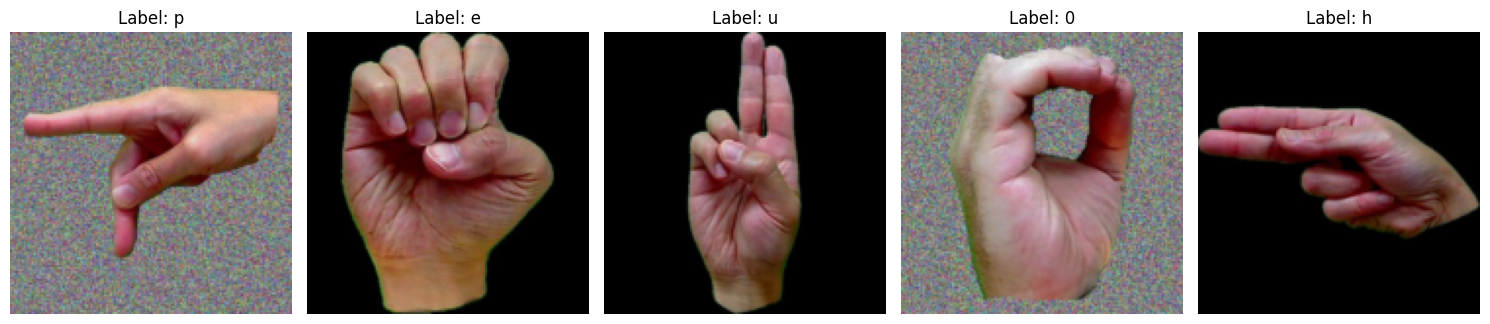

In [4]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Use antialias=True for better quality on down/upscaling
_RESIZE_SIZE = (144, 144)
_resize_tensor = transforms.Resize(_RESIZE_SIZE, antialias=True)
_resize_pil_and_to_tensor = transforms.Compose([
    transforms.Resize(_RESIZE_SIZE, antialias=True),
    transforms.ToTensor()
])

class ResizedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, resize=(144,144)):
        self.base = base_dataset
        self.resize = transforms.Resize(resize, antialias=True)
        self.classes = getattr(base_dataset, "classes", None)

        # Try to mirror label attributes
        if hasattr(base_dataset, "targets"):
            self.targets = list(base_dataset.targets)
        elif hasattr(base_dataset, "labels"):
            self.targets = list(base_dataset.labels)
        elif hasattr(base_dataset, "samples"):
            self.targets = [lbl for _, lbl in base_dataset.samples]
        elif hasattr(base_dataset, "imgs"):
            self.targets = [lbl for _, lbl in base_dataset.imgs]
        else:
            # Lazy compute (optional): comment out to avoid up-front cost
            self.targets = [base_dataset[i][1] for i in range(len(base_dataset))]

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        if isinstance(img, torch.Tensor):          # (C,H,W)
            img = self.resize(img)
        else:                                      # PIL/ndarray
            img = self.resize(img)
            img = transforms.ToTensor()(img)
        return img, label


# Wrap your dataset
resized_dataset = ResizedDataset(final_combined_dataset_after_aug)
class_names = resized_dataset.classes

print("✅ Resized augmented combined dataset to (144, 144)")
print(f"Total images: {len(resized_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# --- visualize ---
num_images_to_show = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_show):
    idx = random.randint(0, len(resized_dataset) - 1)
    img_tensor, label_idx = resized_dataset[idx]  # img_tensor is (C, 144, 144)

    # Convert to HWC for matplotlib
    img_np = img_tensor.permute(1, 2, 0).numpy()
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img_np)
    plt.title(f"Label: {class_names[label_idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Load the full combined dataset
# Ensure the correct transforms are applied when loading the dataset
full_combined_dataset = resized_dataset

print(f"Total images in the combined dataset: {len(full_combined_dataset)}")
print(f"Number of classes: {len(full_combined_dataset.classes)}")
print(f"Class names: {full_combined_dataset.classes}")

# Get the indices and labels for splitting
indices = list(range(len(full_combined_dataset)))
labels = [full_combined_dataset.targets[i] for i in indices]

# --- Perform the train-validation-test split on indices ---

# First, split into training (70%) and a temporary set (30% for validation + test)
train_indices, temp_indices, _, _ = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)

# Then, split the temporary set into validation (50% of temp, so 15% of total)
# and test (50% of temp, so 15% of total)
temp_labels = [labels[i] for i in temp_indices]
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create PyTorch Subset datasets
train_dataset = Subset(full_combined_dataset, train_indices)
val_dataset = Subset(full_combined_dataset, val_indices)
test_dataset = Subset(full_combined_dataset, test_indices)

print(f"\nTrain set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print("\nTrain, validation, and test datasets created as PyTorch Subset objects.")

Total images in the combined dataset: 6036
Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Train set size: 4225
Validation set size: 905
Test set size: 906

Train, validation, and test datasets created as PyTorch Subset objects.


In [9]:
# ===================== ViT LoRA Fine-tuning for ASL Dataset =====================
# Full training pipeline with LoRA for efficient fine-tuning
# ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time

# Check if peft is installed, if not provide installation instructions
try:
    from peft import LoraConfig
    from peft.tuners.lora import LoraModel
    PEFT_AVAILABLE = True
except ImportError:
    PEFT_AVAILABLE = False
    print("WARNING: peft library not found. Install with: pip install peft")
    print("Continuing without LoRA (will use partial fine-tuning instead)")

# Import timm for Vision Transformer models
try:
    import timm
except ImportError:
    raise ImportError("timm library required. Install with: pip install timm")

# ======================== Configuration ========================
class Config:
    # Paths
    dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'
    save_dir = './vit_lora_checkpoints'
    
    # Model settings
    model_name = 'vit_base_patch16_224'  # e.g. vit_base_patch16_224, vit_small_patch16_224
    pretrained = True
    num_classes = 36
    image_size = 224  # ViT typically uses 224x224
    
    # LoRA settings (only used if peft is available)
    lora_r = 8           # Rank of LoRA matrices
    lora_alpha = 16      # Scaling factor
    lora_dropout = 0.1
    lora_target_modules = ["qkv"]  # Apply LoRA to attention qkv layers
    
    # Training settings
    batch_size = 32
    num_epochs = 30
    learning_rate = 1e-4
    weight_decay = 0.01
    warmup_epochs = 2
    
    # Data split
    train_ratio = 0.70
    val_ratio = 0.15
    test_ratio = 0.15
    
    # Hardware
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 4
    
    # Logging
    print_freq = 10
    save_best_only = True

config = Config()
Path(config.save_dir).mkdir(parents=True, exist_ok=True)

print(f"Using device: {config.device}")
print(f"LoRA available: {PEFT_AVAILABLE}")

# ======================== Data Preparation ========================
# Define transforms with data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(config.image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print(f"\nLoading dataset from {config.dataset_root}...")
full_dataset = datasets.ImageFolder(config.dataset_root)
class_names = full_dataset.classes
num_classes = len(class_names)

print(f"Total images: {len(full_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Split dataset
train_size = int(config.train_ratio * len(full_dataset))
val_size = int(config.val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Wrapper so each subset can have its own transform
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

train_dataset = SubsetWithTransform(train_subset, train_transforms)
val_dataset   = SubsetWithTransform(val_subset, val_test_transforms)
test_dataset  = SubsetWithTransform(test_subset, val_test_transforms)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=(config.device == 'cuda')
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=(config.device == 'cuda')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=(config.device == 'cuda')
)

# ======================== Model Setup ========================
print(f"\nLoading model: {config.model_name}")
model = timm.create_model(
    config.model_name,
    pretrained=config.pretrained,
    num_classes=config.num_classes
)

# Apply LoRA if available
if PEFT_AVAILABLE:
    print("Applying LoRA with LoraModel (timm-compatible)...")
    lora_config = LoraConfig(
        r=config.lora_r,
        lora_alpha=config.lora_alpha,
        target_modules=config.lora_target_modules,
        lora_dropout=config.lora_dropout,
        bias="none",
        task_type="FEATURE_EXTRACTION"  # not really used for timm, but ok
    )
    # ✅ FIX: pass adapter_name explicitly
    model = LoraModel(model, lora_config, adapter_name="default")

    if hasattr(model, "print_trainable_parameters"):
        model.print_trainable_parameters()
    else:
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in model.parameters())
        print(f"Trainable params: {trainable} / {total} ({100*trainable/total:.2f}%)")
else:
    print("LoRA not available — freezing backbone, training classifier head only.")
    for param in model.parameters():
        param.requires_grad = False
    for param in model.get_classifier().parameters():
        param.requires_grad = True

model = model.to(config.device)

# ======================== Training Setup ========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Learning rate scheduler with warmup + cosine
def get_lr_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # cosine decay
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, config.warmup_epochs, config.num_epochs)

# ======================== Training Functions ========================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # LoraModel keeps forward(x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100. * correct / total:.2f}"
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100. * correct / total:.2f}"
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ======================== Training Loop ========================
print("\n" + "="*50)
print("Starting Training")
print("="*50)

best_val_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

start_time = time.time()

epoch_iterator = tqdm(range(config.num_epochs), desc="Epochs")
for epoch in epoch_iterator:
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, config.device)
    
    # Scheduler step
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Update outer tqdm
    epoch_iterator.set_postfix({
        'train_acc': f"{train_acc:.2f}",
        'val_acc': f"{val_acc:.2f}",
        'lr': f"{current_lr:.2e}"
    })
    
    # Print stats
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = Path(config.save_dir) / 'best_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"✓ New best model saved with Val Acc: {val_acc:.2f}%")

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# ======================== Evaluation on Test Set ========================
print("\n" + "="*50)
print("Evaluating on Test Set")
print("="*50)

checkpoint = torch.load(Path(config.save_dir) / 'best_model.pth',
                        map_location=config.device)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = validate(model, test_loader, criterion, config.device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# ======================== Plot Training History ========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.axhline(y=test_acc, linestyle='--',
            label=f'Test Acc ({test_acc:.2f}%)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(Path(config.save_dir) / 'training_history.png', dpi=150)
plt.show()

print(f"\nTraining history plot saved to {Path(config.save_dir) / 'training_history.png'}")
print("\n" + "="*50)
print("Training Complete!")
print("="*50)


Using device: cuda
LoRA available: True

Loading dataset from /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined...
Total images: 6036
Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train set size: 4225
Validation set size: 905
Test set size: 906

Loading model: vit_base_patch16_224
Applying LoRA with LoraModel (timm-compatible)...
Trainable params: 294912 / 86121252 (0.34%)

Starting Training


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1/30
--------------------------------------------------


Epochs:   3%|▎         | 1/30 [00:23<11:19, 23.45s/it, train_acc=3.34, val_acc=3.54, lr=1.00e-04]

Train Loss: 3.7450 | Train Acc: 3.34%
Val   Loss: 3.5967 | Val   Acc: 3.54%
Learning Rate: 0.000100
✓ New best model saved with Val Acc: 3.54%

Epoch 2/30
--------------------------------------------------


Epochs:   3%|▎         | 1/30 [00:46<11:19, 23.45s/it, train_acc=13.59, val_acc=34.48, lr=1.00e-04]

Train Loss: 3.1431 | Train Acc: 13.59%
Val   Loss: 2.2637 | Val   Acc: 34.48%
Learning Rate: 0.000100


Epochs:   7%|▋         | 2/30 [00:46<10:51, 23.25s/it, train_acc=13.59, val_acc=34.48, lr=1.00e-04]

✓ New best model saved with Val Acc: 34.48%

Epoch 3/30
--------------------------------------------------


Epochs:   7%|▋         | 2/30 [01:09<10:51, 23.25s/it, train_acc=57.23, val_acc=76.24, lr=9.97e-05]

Train Loss: 1.4933 | Train Acc: 57.23%
Val   Loss: 0.9357 | Val   Acc: 76.24%
Learning Rate: 0.000100


Epochs:  10%|█         | 3/30 [01:09<10:26, 23.22s/it, train_acc=57.23, val_acc=76.24, lr=9.97e-05]

✓ New best model saved with Val Acc: 76.24%

Epoch 4/30
--------------------------------------------------


Epochs:  10%|█         | 3/30 [01:32<10:26, 23.22s/it, train_acc=82.08, val_acc=82.43, lr=9.87e-05]

Train Loss: 0.6912 | Train Acc: 82.08%
Val   Loss: 0.5754 | Val   Acc: 82.43%
Learning Rate: 0.000099


Epochs:  13%|█▎        | 4/30 [01:32<10:03, 23.23s/it, train_acc=82.08, val_acc=82.43, lr=9.87e-05]

✓ New best model saved with Val Acc: 82.43%

Epoch 5/30
--------------------------------------------------


Epochs:  13%|█▎        | 4/30 [01:56<10:03, 23.23s/it, train_acc=88.45, val_acc=87.73, lr=9.72e-05]

Train Loss: 0.4191 | Train Acc: 88.45%
Val   Loss: 0.4199 | Val   Acc: 87.73%
Learning Rate: 0.000097


Epochs:  17%|█▋        | 5/30 [01:56<09:41, 23.26s/it, train_acc=88.45, val_acc=87.73, lr=9.72e-05]

✓ New best model saved with Val Acc: 87.73%

Epoch 6/30
--------------------------------------------------


Epochs:  17%|█▋        | 5/30 [02:19<09:41, 23.26s/it, train_acc=90.13, val_acc=92.04, lr=9.50e-05]

Train Loss: 0.3457 | Train Acc: 90.13%
Val   Loss: 0.2552 | Val   Acc: 92.04%
Learning Rate: 0.000095


Epochs:  20%|██        | 6/30 [02:19<09:18, 23.28s/it, train_acc=90.13, val_acc=92.04, lr=9.50e-05]

✓ New best model saved with Val Acc: 92.04%

Epoch 7/30
--------------------------------------------------


Epochs:  20%|██        | 6/30 [02:42<09:18, 23.28s/it, train_acc=92.52, val_acc=93.59, lr=9.23e-05]

Train Loss: 0.2650 | Train Acc: 92.52%
Val   Loss: 0.2063 | Val   Acc: 93.59%
Learning Rate: 0.000092


Epochs:  23%|██▎       | 7/30 [02:43<08:56, 23.32s/it, train_acc=92.52, val_acc=93.59, lr=9.23e-05]

✓ New best model saved with Val Acc: 93.59%

Epoch 8/30
--------------------------------------------------


Epochs:  23%|██▎       | 7/30 [03:06<08:56, 23.32s/it, train_acc=94.01, val_acc=94.92, lr=8.91e-05]

Train Loss: 0.2016 | Train Acc: 94.01%
Val   Loss: 0.1730 | Val   Acc: 94.92%
Learning Rate: 0.000089


Epochs:  27%|██▋       | 8/30 [03:06<08:32, 23.32s/it, train_acc=94.01, val_acc=94.92, lr=8.91e-05]

✓ New best model saved with Val Acc: 94.92%

Epoch 9/30
--------------------------------------------------


Epochs:  30%|███       | 9/30 [03:29<08:08, 23.26s/it, train_acc=94.37, val_acc=94.48, lr=8.54e-05]

Train Loss: 0.1758 | Train Acc: 94.37%
Val   Loss: 0.1537 | Val   Acc: 94.48%
Learning Rate: 0.000085

Epoch 10/30
--------------------------------------------------


Epochs:  30%|███       | 9/30 [03:52<08:08, 23.26s/it, train_acc=95.76, val_acc=95.36, lr=8.12e-05]

Train Loss: 0.1480 | Train Acc: 95.76%
Val   Loss: 0.1476 | Val   Acc: 95.36%
Learning Rate: 0.000081


Epochs:  33%|███▎      | 10/30 [03:52<07:45, 23.29s/it, train_acc=95.76, val_acc=95.36, lr=8.12e-05]

✓ New best model saved with Val Acc: 95.36%

Epoch 11/30
--------------------------------------------------


Epochs:  33%|███▎      | 10/30 [04:15<07:45, 23.29s/it, train_acc=95.88, val_acc=96.35, lr=7.66e-05]

Train Loss: 0.1317 | Train Acc: 95.88%
Val   Loss: 0.1135 | Val   Acc: 96.35%
Learning Rate: 0.000077


Epochs:  37%|███▋      | 11/30 [04:16<07:22, 23.30s/it, train_acc=95.88, val_acc=96.35, lr=7.66e-05]

✓ New best model saved with Val Acc: 96.35%

Epoch 12/30
--------------------------------------------------


Epochs:  37%|███▋      | 11/30 [04:39<07:22, 23.30s/it, train_acc=97.02, val_acc=97.02, lr=7.17e-05]

Train Loss: 0.1166 | Train Acc: 97.02%
Val   Loss: 0.1052 | Val   Acc: 97.02%
Learning Rate: 0.000072


Epochs:  40%|████      | 12/30 [04:39<07:00, 23.34s/it, train_acc=97.02, val_acc=97.02, lr=7.17e-05]

✓ New best model saved with Val Acc: 97.02%

Epoch 13/30
--------------------------------------------------


Epochs:  40%|████      | 12/30 [05:02<07:00, 23.34s/it, train_acc=97.18, val_acc=97.24, lr=6.65e-05]

Train Loss: 0.1039 | Train Acc: 97.18%
Val   Loss: 0.1104 | Val   Acc: 97.24%
Learning Rate: 0.000067


Epochs:  43%|████▎     | 13/30 [05:02<06:36, 23.33s/it, train_acc=97.18, val_acc=97.24, lr=6.65e-05]

✓ New best model saved with Val Acc: 97.24%

Epoch 14/30
--------------------------------------------------


Epochs:  47%|████▋     | 14/30 [05:25<06:12, 23.25s/it, train_acc=97.47, val_acc=97.02, lr=6.11e-05]

Train Loss: 0.0897 | Train Acc: 97.47%
Val   Loss: 0.1064 | Val   Acc: 97.02%
Learning Rate: 0.000061

Epoch 15/30
--------------------------------------------------


Epochs:  47%|████▋     | 14/30 [05:48<06:12, 23.25s/it, train_acc=97.35, val_acc=97.90, lr=5.56e-05]

Train Loss: 0.0981 | Train Acc: 97.35%
Val   Loss: 0.0771 | Val   Acc: 97.90%
Learning Rate: 0.000056


Epochs:  50%|█████     | 15/30 [05:49<05:48, 23.25s/it, train_acc=97.35, val_acc=97.90, lr=5.56e-05]

✓ New best model saved with Val Acc: 97.90%

Epoch 16/30
--------------------------------------------------


Epochs:  53%|█████▎    | 16/30 [06:12<05:24, 23.17s/it, train_acc=97.56, val_acc=97.57, lr=5.00e-05]

Train Loss: 0.0840 | Train Acc: 97.56%
Val   Loss: 0.0767 | Val   Acc: 97.57%
Learning Rate: 0.000050

Epoch 17/30
--------------------------------------------------


Epochs:  53%|█████▎    | 16/30 [06:35<05:24, 23.17s/it, train_acc=97.94, val_acc=98.90, lr=4.44e-05]

Train Loss: 0.0800 | Train Acc: 97.94%
Val   Loss: 0.0663 | Val   Acc: 98.90%
Learning Rate: 0.000044


Epochs:  57%|█████▋    | 17/30 [06:35<05:01, 23.21s/it, train_acc=97.94, val_acc=98.90, lr=4.44e-05]

✓ New best model saved with Val Acc: 98.90%

Epoch 18/30
--------------------------------------------------


Epochs:  60%|██████    | 18/30 [06:58<04:37, 23.14s/it, train_acc=98.20, val_acc=98.56, lr=3.89e-05]

Train Loss: 0.0651 | Train Acc: 98.20%
Val   Loss: 0.0639 | Val   Acc: 98.56%
Learning Rate: 0.000039

Epoch 19/30
--------------------------------------------------


Epochs:  63%|██████▎   | 19/30 [07:21<04:14, 23.12s/it, train_acc=98.46, val_acc=98.67, lr=3.35e-05]

Train Loss: 0.0594 | Train Acc: 98.46%
Val   Loss: 0.0604 | Val   Acc: 98.67%
Learning Rate: 0.000033

Epoch 20/30
--------------------------------------------------


Epochs:  63%|██████▎   | 19/30 [07:44<04:14, 23.12s/it, train_acc=98.49, val_acc=99.01, lr=2.83e-05]

Train Loss: 0.0590 | Train Acc: 98.49%
Val   Loss: 0.0566 | Val   Acc: 99.01%
Learning Rate: 0.000028


Epochs:  67%|██████▋   | 20/30 [07:44<03:51, 23.15s/it, train_acc=98.49, val_acc=99.01, lr=2.83e-05]

✓ New best model saved with Val Acc: 99.01%

Epoch 21/30
--------------------------------------------------


Epochs:  70%|███████   | 21/30 [08:07<03:28, 23.12s/it, train_acc=98.67, val_acc=98.45, lr=2.34e-05]

Train Loss: 0.0525 | Train Acc: 98.67%
Val   Loss: 0.0649 | Val   Acc: 98.45%
Learning Rate: 0.000023

Epoch 22/30
--------------------------------------------------


Epochs:  73%|███████▎  | 22/30 [08:30<03:04, 23.08s/it, train_acc=98.72, val_acc=98.67, lr=1.88e-05]

Train Loss: 0.0511 | Train Acc: 98.72%
Val   Loss: 0.0541 | Val   Acc: 98.67%
Learning Rate: 0.000019

Epoch 23/30
--------------------------------------------------


Epochs:  77%|███████▋  | 23/30 [08:53<02:41, 23.05s/it, train_acc=98.82, val_acc=98.90, lr=1.46e-05]

Train Loss: 0.0513 | Train Acc: 98.82%
Val   Loss: 0.0556 | Val   Acc: 98.90%
Learning Rate: 0.000015

Epoch 24/30
--------------------------------------------------


Epochs:  80%|████████  | 24/30 [09:16<02:18, 23.06s/it, train_acc=99.12, val_acc=98.12, lr=1.09e-05]

Train Loss: 0.0462 | Train Acc: 99.12%
Val   Loss: 0.0573 | Val   Acc: 98.12%
Learning Rate: 0.000011

Epoch 25/30
--------------------------------------------------


Epochs:  83%|████████▎ | 25/30 [09:39<01:55, 23.08s/it, train_acc=98.86, val_acc=98.67, lr=7.66e-06]

Train Loss: 0.0477 | Train Acc: 98.86%
Val   Loss: 0.0526 | Val   Acc: 98.67%
Learning Rate: 0.000008

Epoch 26/30
--------------------------------------------------


Epochs:  87%|████████▋ | 26/30 [10:03<01:32, 23.08s/it, train_acc=98.98, val_acc=99.01, lr=4.95e-06]

Train Loss: 0.0442 | Train Acc: 98.98%
Val   Loss: 0.0495 | Val   Acc: 99.01%
Learning Rate: 0.000005

Epoch 27/30
--------------------------------------------------


Epochs:  90%|█████████ | 27/30 [10:26<01:09, 23.06s/it, train_acc=99.10, val_acc=99.01, lr=2.81e-06]

Train Loss: 0.0425 | Train Acc: 99.10%
Val   Loss: 0.0493 | Val   Acc: 99.01%
Learning Rate: 0.000003

Epoch 28/30
--------------------------------------------------


Epochs:  93%|█████████▎| 28/30 [10:49<00:46, 23.07s/it, train_acc=98.93, val_acc=98.90, lr=1.25e-06]

Train Loss: 0.0468 | Train Acc: 98.93%
Val   Loss: 0.0495 | Val   Acc: 98.90%
Learning Rate: 0.000001

Epoch 29/30
--------------------------------------------------


Epochs:  97%|█████████▋| 29/30 [11:12<00:23, 23.07s/it, train_acc=98.98, val_acc=98.90, lr=3.14e-07]

Train Loss: 0.0427 | Train Acc: 98.98%
Val   Loss: 0.0493 | Val   Acc: 98.90%
Learning Rate: 0.000000

Epoch 30/30
--------------------------------------------------


Epochs: 100%|██████████| 30/30 [11:35<00:00, 23.18s/it, train_acc=99.08, val_acc=99.01, lr=0.00e+00]


Train Loss: 0.0425 | Train Acc: 99.08%
Val   Loss: 0.0489 | Val   Acc: 99.01%
Learning Rate: 0.000000

Training completed in 11.59 minutes
Best Validation Accuracy: 99.01%

Evaluating on Test Set


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.